In [0]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
from scipy import poly1d
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import datetime
from scipy import stats
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [0]:
#data is the SSE 50 index
data = get_price('000016.XSHG',start_date='2015-01-01',end_date='2016-06-30',frequency='daily')
data.head()

,open,close,high,low,volume,money
2015-01-05,2612.85,2649.64,2678.44,2583.55,1.824256e+10,2.297636e+11
2015-01-06,2616.29,2629.40,2691.49,2591.83,1.734400e+10,2.206018e+11
2015-01-07,2608.88,2635.23,2668.84,2598.89,1.283177e+10,1.783861e+11
2015-01-08,2647.82,2558.11,2656.75,2551.82,1.183679e+10,1.570658e+11
2015-01-09,2554.29,2569.02,2692.61,2540.34,1.562095e+10,2.110058e+11


In [0]:
Close = data['close']
High = data['high']
Low = data['low']
Volume = data['volume']

In [0]:
# initial Kalman Filter
KF = KalmanFilter(transition_matrices=[1],
                 observation_matrices=[1],
                 initial_state_mean=2649.64,
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)
states_means,_ = KF.filter(Close)

In [0]:
Date = pd.to_datetime(data.index)

In [0]:
states_means = pd.DataFrame({'Date':Date,'states_means':pd.DataFrame(states_means)[0]}).set_index('Date')

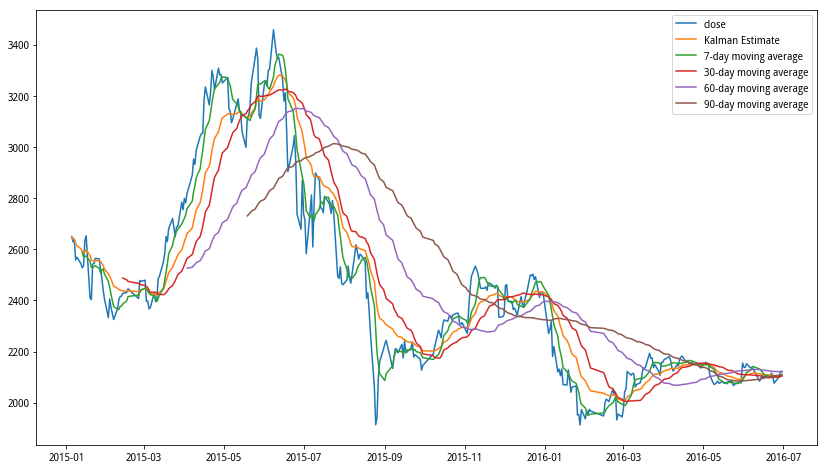

In [0]:
# compare Kalman Filter with 7-day, 30-day, 60-day and 90-day moving average
mean7 = Close.rolling(7).mean()
mean30 = Close.rolling(30).mean()
mean60 = Close.rolling(60).mean()
mean90 = Close.rolling(90).mean()
plt.figure(figsize(14,8))
plt.plot(Close)
plt.plot(states_means)
plt.plot(mean7)
plt.plot(mean30)
plt.plot(mean60)
plt.plot(mean90)
plt.legend(['close','Kalman Estimate','7-day moving average','30-day moving average','60-day moving average','90-day moving average'])
plt.show()

### Kalman+HMM combination model

In [0]:
data1 = get_price('000016.XSHG',start_date='2008-03-17',end_date='2018-03-17',frequency='daily')

In [0]:
Close1 = data1['close']
High1 = data1['high']
Low1 = data1['low']
Volume1 = data1['volume']

In [0]:
# calculate the adjusted close price
KF1 = KalmanFilter(transition_matrices=[1],
                 observation_matrices=[1],
                 initial_state_mean=Close1[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)
close_means,_ = KF1.filter(Close1)

Date1 = pd.to_datetime(data1.index)
close_means = pd.DataFrame({'Date':Date1,'close_means':pd.DataFrame(close_means)[0]}).set_index('Date')

In [0]:
# calculate the adjusted high price
KF2 = KalmanFilter(transition_matrices=[1],
                 observation_matrices=[1],
                 initial_state_mean=High1[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)
high_means,_ = KF2.filter(High1)

high_means = pd.DataFrame({'Date':Date1,'high_means':pd.DataFrame(high_means)[0]}).set_index('Date')

In [0]:
# calculate the adjusted low price
KF3 = KalmanFilter(transition_matrices=[1],
                 observation_matrices=[1],
                 initial_state_mean=Low1[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)
low_means,_ = KF3.filter(Low1)

low_means = pd.DataFrame({'Date':Date1,'low_means':pd.DataFrame(low_means)[0]}).set_index('Date')

In [0]:
# calculate the adjusted volume
KF4 = KalmanFilter(transition_matrices=[1],
                 observation_matrices=[1],
                 initial_state_mean=Volume1[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)
volume_means,_ = KF4.filter(Volume1)

volume_means = pd.DataFrame({'Date':Date1,'volume_means':pd.DataFrame(volume_means)[0]}).set_index('Date')

In [0]:
# compute characteristic variables
logdif = np.log(np.array(high_means['high_means']))-np.log(np.array(low_means['low_means']))
logret5 = np.log(np.array(close_means['close_means'][5:]))-np.log(np.array(close_means['close_means'][:-5]))
logvoldif5 = np.log(np.array(volume_means['volume_means'][5:]))-np.log(np.array(volume_means['volume_means'][:-5]))

In [0]:
# adjust the length of characteristic variables
logdif = logdif[5:]
close = data1['close'][5:]
Date = pd.to_datetime(data1.index[5:])

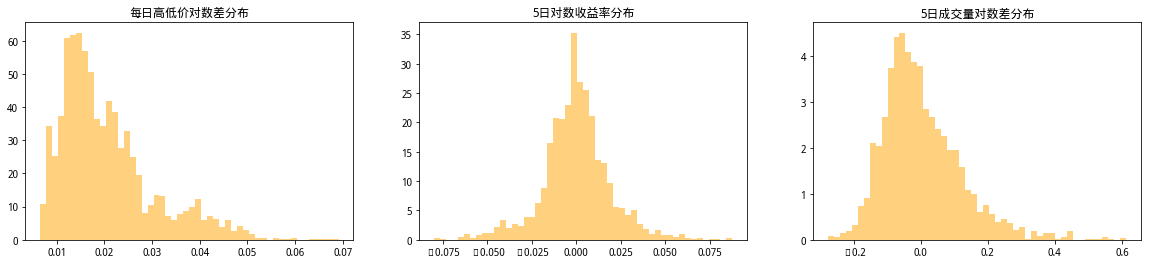

In [0]:
# plot the distribution
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(1,3,1)
plt.hist(logdif,50,normed=1,facecolor='orange',alpha=0.5)
plt.title('每日高低价对数差分布')
ax2 = fig.add_subplot(1,3,2)
plt.hist(logret5,50,normed=1,facecolor='orange',alpha=0.5)
plt.title('5日对数收益率分布')
ax3 = fig.add_subplot(1,3,3)
plt.hist(logvoldif5,50,normed=1,facecolor='orange',alpha=0.5)
plt.title('5日成交量对数差分布')
plt.show()

In [0]:
# use Box-Cox transformation to adjust the distribution of variable into normal distribution
bc_logdif,_ = stats.boxcox(logdif)
scale_bc_logdif = preprocessing.scale(bc_logdif,axis=0,with_mean=True,with_std=True,copy=False)
scale_logret5 = preprocessing.scale(logret5,axis=0,with_mean=True,with_std=True,copy=False)
scale_logvoldif5 = preprocessing.scale(logvoldif5,axis=0,with_mean=True,with_std=True,copy=False)

In [0]:
# predict the hidden states
scaleA = np.column_stack([scale_bc_logdif,scale_logret5,scale_logvoldif5])
HMMmodel = GaussianHMM(n_components=4,covariance_type='full',n_iter=2000).fit(scaleA)
hidden_states = HMMmodel.predict(scaleA)
hidden_states

array([1, 1, 1, ..., 2, 2, 2])

In [0]:
plt.figure(figsize=(10,5))
for i in range(HMMmodel.n_components):
    pos = hidden_states==i
    plt.plot_date(Date[pos],close[pos],'o',label='hidden state %d'%i)
    plt.legend(loc='left')

In [0]:
true_logret1 = np.array(np.diff(np.log(data1['close'])))[4:]
res = pd.DataFrame({'Date':Date,'true_logret1':true_logret1,'states':hidden_states}).set_index('Date')
plt.figure(figsize=(10,5))
for i in range(4):
    pos = (hidden_states==i)
    pos = np.append(0,pos[:-1])
    df = res['true_logret1']
    res['state %d return'%i] = df.multiply(pos)
    plt.plot_date(Date,np.exp(res['state %d return'%i].cumsum()),'-',label='hidden state %d cumreturn'%i)
    plt.legend(loc='left')

In [0]:
long = (hidden_states==0)+(hidden_states==2)
short = (hidden_states==1)+(hidden_states==3)
long = np.append(0,long[:-1])
short = np.append(0,short[:-1])
res['cumreturn'] = df.multiply(long)-df.multiply(short)
plt.plot_date(Date,np.exp(res['cumreturn'].cumsum()),'-')

In [0]:
# set position adjustment period equals to 30 days
hidden_states30 = [np.argmax(np.bincount(hidden_states[i:i+30])) for i in range(0,len(hidden_states),30)]

In [0]:
hidden_states30 = np.array(hidden_states30)

In [0]:
Date30 = [Date[i] for i in range(0,len(Date),30)]
Date30 = pd.to_datetime(Date30)

In [0]:
close30 = [close[i] for i in range(0,len(close),30)]
close30 = pd.DataFrame({'Date':Date30,'close30':close30})

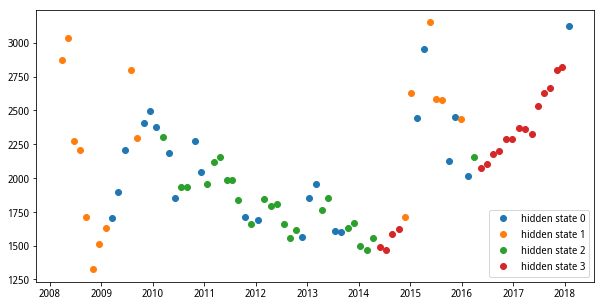

In [0]:
plt.figure(figsize=(10,5))
for i in range(HMMmodel.n_components):
    pos = hidden_states30==i
    plt.plot_date(Date30[pos],close30['close30'][pos],'o',label='hidden state %d'%i)
    plt.legend(loc='left')

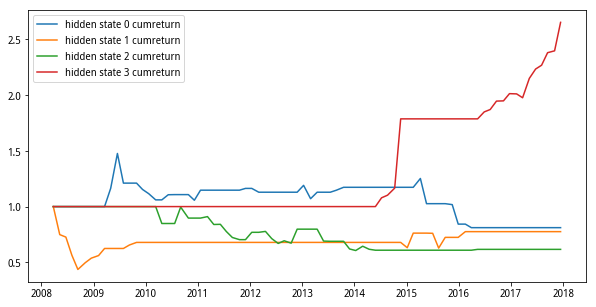

In [0]:
# plot cumulative returns
true_logret30 = np.array(np.diff(np.log(close30['close30'])))
res = pd.DataFrame({'Date':Date30[:-1],'true_logret30':true_logret30,'states':hidden_states30[:-1]}).set_index('Date')
plt.figure(figsize=(10,5))
for i in range(4):
    pos = (hidden_states30[:-1]==i)
    pos = np.append(0,pos[:-1])
    df = res['true_logret30']
    res['state %d return'%i] = df.multiply(pos)
    plt.plot_date(Date30[:-1],np.exp(res['state %d return'%i].cumsum()),'-',label='hidden state %d cumreturn'%i)
    plt.legend(loc='left')

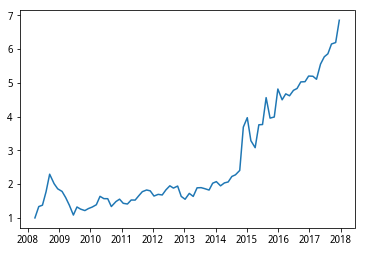

In [0]:
long = (hidden_states30[:-1]==3)
short = (hidden_states30[:-1]==1)+(hidden_states30[:-1]==0)+(hidden_states30[:-1]==2)
long = np.append(0,long[:-1])
short = np.append(0,short[:-1])
res['cumreturn'] = df.multiply(long)-df.multiply(short)
plt.plot_date(Date30[:-1],np.exp(res['cumreturn'].cumsum()),'-')